In [3]:
import simpleaudio as sa
filename='../data/PMPM_RAW_BIN_10s_20241021_094654.csv'
print('Reading file:',filename)

Reading file: ../data/PMPM_RAW_BIN_10s_20241021_094654.csv


In [4]:
# Lire le fichier .csv qui contient le flux de bytes
with open(filename, 'rb') as f:
    byte_stream = f.read()  # Lire tout le fichier comme un flux de bytes
print(byte_stream[0:20])


b'\x00\x00\xec\xff\xef\xff\xf0\xff\xef\xff\xef\xff\xf4\xff\xf2\xff\xf1\xff\xed\xff'


In [5]:
import  struct
num_values = len(byte_stream) // 2  # Calcul du nombre d'entiers
values = []
for i in range(num_values):
    two_bytes = byte_stream[i*2:(i*2)+2]
    value = struct.unpack('<h', two_bytes)[0]  # '<h' pour 2 bytes en short int
    values.append(value)

In [6]:
print(values[:105])
print(len(values))

[0, -20, -17, -16, -17, -17, -12, -14, -15, -19, -17, -19, -20, -19, -15, -19, -19, -20, -20, -17, -16, -17, -17, -16, -16, -16, -20, -19, -17, -16, -17, -16, -17, -15, -16, -14, -14, -15, -16, -20, -24, -16, -19, -16, -15, -20, -19, -15, -19, -19, -20, 0, -20, -19, -16, -14, -14, -12, -14, -16, -16, -16, -19, -16, -17, -15, -15, -16, -17, -16, -17, -19, -15, -16, -17, -17, -16, -19, -20, -20, -17, -16, -16, -17, -16, -17, -17, -17, -19, -15, -17, -20, -17, -15, -17, -17, -16, -15, -16, -14, -19, -19, 0, -19, -19]
510000


In [7]:
import numpy as np

npValues=np.array(values, dtype=np.int16)
start_size=1
sound_size=50
slice_size=start_size+sound_size
num_slice = len(npValues)//slice_size # Nombre de tranches

start_indices=np.concatenate([np.arange(i*slice_size, i*slice_size+start_size) for i in range(num_slice)])
sound_indices=np.concatenate([np.arange(i*slice_size, i*slice_size+sound_size) for i in range(num_slice)])
startValues=npValues[start_indices]
soundValues=npValues[sound_indices]


In [8]:
print(startValues[:10])
print(len(startValues), startValues.shape, np.max(startValues), np.min(startValues))
print(soundValues[:10])
print(len(soundValues), soundValues.shape,np.max(soundValues),np.min(soundValues))
print(len(npValues), npValues.shape)
print(num_slice)


[0 0 0 0 0 0 0 0 0 0]
10000 (10000,) 0 0
[  0 -20 -17 -16 -17 -17 -12 -14 -15 -19]
500000 (500000,) 39 -91
510000 (510000,)
10000


In [33]:


import scipy.signal as signal

fs=50000
ft=44100
amplify=1.5
#audio = values*(2**15-1)/np.max(np.abs(values))
audio = soundValues.copy()
print(audio[:20])
# Convert to 16-bit data
#audio = audio.astype(np.int16)
audio_resampled = signal.resample(audio, int(len(audio)*ft/fs))
print(len(audio_resampled), audio_resampled.shape,np.max(audio_resampled),np.min(audio_resampled))
audio_resampled = np.int16(audio_resampled*(2**15-1)/np.max(np.abs(audio_resampled)))
print(len(audio_resampled), audio_resampled.shape,np.max(audio_resampled),np.min(audio_resampled))


audio_amplified = audio_resampled*amplify
audio_amplified=np.clip(audio_amplified, -2**15, 2**15-1)
audio_amplified=np.int16(audio_amplified)
print(len(audio_amplified), audio_amplified.shape,np.max(audio_amplified),np.min(audio_amplified))



[  0 -25 -23 -23 -28 -25 -24 -24 -24 -24 -25 -25 -24 -28 -23 -23 -24 -23
 -28 -28]
2646000 (2646000,) 676.7079052682199 -703.7778157327624
2646000 (2646000,) 31506 -32767
2646000 (2646000,) 32767 -32768


In [10]:
# Start playback
play_obj = sa.play_buffer(audio_amplified, 1, 2, ft)

# Wait for playback to finish before exiting
play_obj.wait_done()

In [11]:
play_obj = sa.play_buffer(audio_amplified, 1, 2, ft)


In [12]:
play_obj.wait_done()

In [13]:
from scipy.io import wavfile

# Exemple d'array numpy (ton tableau d'entiers)
data = audio_amplified.copy()  # Remplace par ton tableau réel

# Définir la fréquence d'échantillonnage (par exemple, 44100 Hz)
sampling_rate = ft  # Fréquence d'échantillonnage en Hz

# Enregistrer en fichier .wav
wavfile.write("firstRecording.wav", sampling_rate, data)

print("Fichier .wav enregistré avec succès.")

Fichier .wav enregistré avec succès.


In [14]:
factor = 1
oversampled_data = np.zeros(len(audio) * factor)
oversampled_data[::factor] = audio  # Insère les données réelles tous les "factor" échantillons

# Application d'un filtre passe-bas numérique
nyquist_freq = 0.5 / factor  # Fréquence de Nyquist du signal suréchantillonné
b, a = signal.butter(4, nyquist_freq, btype='low')  # Filtre passe-bas Butterworth
filtered_data = signal.filtfilt(b, a, oversampled_data)
filtered_data = np.int16(filtered_data*(2**15-1)/np.max(np.abs(filtered_data)))
audio_resampled = signal.resample(filtered_data, int(len(audio)*(ft/2)/(fs*factor)))



sample_rate = 50000
cutoff_freq = [500, 4500]  # Fréquence de coupure à 20 kHz
nyquist_freq = sample_rate / 2  # Fréquence de Nyquist, ici 25 kHz

# Calcul des coefficients du filtre Butterworth passe-bas
order = 6# Ordre du filtre (tu peux ajuster cela pour rendre la transition plus ou moins nette)
normal_cutoff = [ c / nyquist_freq for c in cutoff_freq]  # Normalisation par rapport à la fréquence de Nyquist
b_b, a_b = signal.butter(order, normal_cutoff, btype='bandpass', analog=False)

# Paramètres du filtre elliptique
#order = 2  # Ordre du filtre
#ripple = 3  # Ripple dans la bande passante (en dB)

# Calcul des coefficients du filtre elliptique
#b, a = signal.ellip(order, ripple, 40, cutoff_freq / nyquist_freq, btype='low', analog=False)

# Application du filtre au signal
filtered_audio = signal.filtfilt(b_b, a_b, audio_resampled)


####################################
#Band stop for the high pitched noise
####################################
cutoff_freq = [4000]  # Fréquence de coupure à 20 kHz
nyquist_freq = sample_rate / 2  # Fréquence de Nyquist, ici 25 kHz
# Calcul des coefficients du filtre Butterworth passe-bas
order = 8 # Ordre du filtre (tu peux ajuster cela pour rendre la transition plus ou moins nette)
normal_cutoff = [ c / nyquist_freq for c in cutoff_freq]  # Normalisation par rapport à la fréquence de Nyquist
b_b, a_b = signal.butter(order, normal_cutoff, btype='low', analog=False)
filtered_audio = signal.filtfilt(b_b, a_b, filtered_audio)
#filtered_audio = signal.filtfilt(b, a, filtered_audio)
print(filtered_audio[:50])
filtered_audio = np.int16(filtered_audio)

[-1.98572727e+00 -5.25059209e+02 -1.00276155e+03 -1.39494982e+03
 -1.67315957e+03 -1.82415636e+03 -1.85104395e+03 -1.77180215e+03
 -1.61556756e+03 -1.41734844e+03 -1.21211620e+03 -1.02929580e+03
 -8.88573872e+02 -7.97679266e+02 -7.52416309e+02 -7.38818623e+02
 -7.36917517e+02 -7.25352437e+02 -6.85937556e+02 -6.07353178e+02
 -4.87335228e+02 -3.33044220e+02 -1.59642785e+02  1.25693781e+01
  1.61879774e+02  2.69049993e+02  3.20686305e+02  3.11547765e+02
  2.45458140e+02  1.34735524e+02 -1.70811652e+00 -1.41251659e+02
 -2.60961587e+02 -3.40978241e+02 -3.67392186e+02 -3.34198443e+02
 -2.44053452e+02 -1.07730956e+02  5.76398221e+01  2.31288139e+02
  3.92049420e+02  5.21630002e+02  6.07351267e+02  6.43905227e+02
  6.33812615e+02  5.86502242e+02  5.16188242e+02  4.38958529e+02
  3.69650934e+02  3.19141611e+02]


In [15]:
#filtered_data = filtered_data.copy(order='C')
#filtered_data = np.int16(filtered_data*(2**15-1)/np.max(np.abs(filtered_data)))
play_obj = sa.play_buffer(filtered_audio, 1, 2, np.int16(ft/2))

play_obj.wait_done()

In [ ]:
print(filtered_data[:1000])

# Doing the job once again with a new set of 1minute Data

In [2]:
import numpy as np
import struct

filename='../data/PMPM_RAW_BIN_60s_20241023_084401.csv'
print('Reading file:',filename)

# Lire le fichier .csv qui contient le flux de bytes
with open(filename, 'rb') as f:
    byte_stream = f.read()  # Lire tout le fichier comme un flux de bytes
num_values = len(byte_stream) // 2  # Calcul du nombre d'entiers
values = []

for i in range(num_values):
    two_bytes = byte_stream[i*2:(i*2)+2]
    value = struct.unpack('<h', two_bytes)[0]  # '<h' pour 2 bytes en short int
    values.append(value)
print("List created with : {} elements".format(len(values)))
    
npValues=np.array(values, dtype=np.int16)
start_size=1
sound_size=50
slice_size=start_size+sound_size
num_slice = len(npValues)//slice_size # Nombre de tranches

start_indices=np.concatenate([np.arange(i*slice_size, i*slice_size+start_size) for i in range(num_slice)])
sound_indices=np.concatenate([np.arange(i*slice_size, i*slice_size+sound_size) for i in range(num_slice)])
startValues=npValues[start_indices]
soundValues=npValues[sound_indices]

fs=50000
sample_table_size = 50
print("Data classified.\n Number of digital samples is : {}, that is {}s \n Number of sampled sound values : {}, that is {}s \n".format(len(startValues), len(startValues)/(fs/sample_table_size), len(soundValues), len(soundValues)/fs))

Reading file: ../data/PMPM_RAW_BIN_60s_20241023_084401.csv
List created with : 3060000 elements
Data classified.
 Number of digital samples is : 60000, that is 60.0s 
 Number of sampled sound values : 3000000, that is 60.0s 


In [94]:
import scipy.signal as signal

#Resampling the audio so that it can be played
ft=44100
audio = soundValues.copy()
print("Length of original audio is : {} \nShape of original audio array is {} \nMax audio value is : {} \nMin audio value is : {}\n".format(len(audio), audio.shape,np.max(audio),np.min(audio)))

# Convert to 16-bit data
audio_resampled = signal.resample(audio, int(len(audio)*ft/fs))
print("Length of resampled audio is : {} \nShape of resampled audio array is {} \nMax sound value is : {} \nMin sound value is : {}\n".format(len(audio_resampled), audio_resampled.shape,np.max(audio_resampled),np.min(audio_resampled)))
audio_resampled = np.int16(audio_resampled*(2**15-1)/np.max(np.abs(audio_resampled)))
print("Length of resampled audio is : {} \nShape of resampled audio array is {} \nMax sound value is : {} \nMin sound value is : {}\n".format(len(audio_resampled), audio_resampled.shape,np.max(audio_resampled),np.min(audio_resampled)))



Length of original audio is : 3000000 
Shape of original audio array is (3000000,) 
Max audio value is : 676 
Min audio value is : -720
Length of resampled audio is : 2646000 
Shape of resampled audio array is (2646000,) 
Max sound value is : 676.7079052682199 
Min sound value is : -703.7778157327624

Length of resampled audio is : 2646000 
Shape of resampled audio array is (2646000,) 
Max sound value is : 31506 
Min sound value is : -32767


In [95]:
import sounddevice as sd
# Start playback
play_resampled = sd.play(audio_resampled[0:176400],samplerate=ft)

sd.wait()




In [96]:
# Amplifying the sound
audio=soundValues.copy()
audio_amplified=np.int16(audio/np.max(np.abs(audio))*(2**15-1))

print("Max amplified sound value is : {} \nMin amplified sound value is : {}\n Max original audio value is : {}\n Min original audio value is : {}".format(np.max(audio_amplified),np.min(audio_amplified), np.max(audio), np.min(audio)))


play_original = sd.play(audio_amplified[0:200000], samplerate=fs)

sd.wait()

Max amplified sound value is : 30764 
Min amplified sound value is : -32767
 Max original audio value is : 676
 Min original audio value is : -720


In [97]:
#Save the recording in .wav
from scipy.io import wavfile

data = audio_resampled.copy()  # Remplace par ton tableau réel


# Enregistrer en fichier .wav
wavfile.write("../data/Resampled_JamesBond.wav", ft, data)
wavfile.write("../data/original_JamesBond.wav", fs, audio_amplified)

print("Fichier .wav enregistré avec succès.")


Fichier .wav enregistré avec succès.


In [141]:
from scipy.fft import fft, fftfreq
#Suppression de la composante DC
audio=soundValues.copy()
audio_amplified=np.int16(audio/np.max(np.abs(audio))*(2**15-1))
audio_amplified=audio_amplified[:200000]-np.mean(audio_amplified[:200000])
#Fenetrage de Hamming
hamming_window = np.hamming(len(audio_amplified))
audio_amplified = audio_amplified*hamming_window
# Calcul de la FFT pour les deux signaux
fft_audio_original = np.abs(fft(audio_amplified))
xf_original = fftfreq(len(audio_amplified), 1/fs)

# Prendre la moitié positive des fréquences
indices_positifs = xf_original > 0
xf_original = xf_original[indices_positifs]
fft_audio_original = np.abs(fft_audio_original[indices_positifs])
# Affichage des spectres
print(fft_audio_original.shape, xf_original.shape)

(99999,) (99999,)


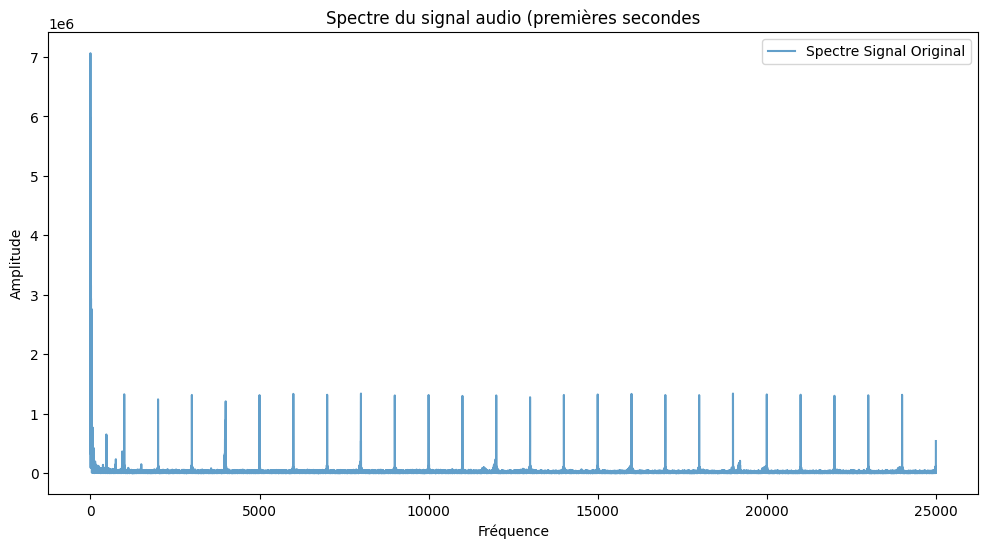

In [145]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(xf_original,fft_audio_original, label='Spectre Signal Original', alpha=0.7)
#plt.plot(xf_resampled,fft_audio_resampled, label='Spectre Signal Resampled', alpha=0.7)
plt.legend()
plt.title('Spectre du signal audio (premières secondes')
plt.xlabel('Fréquence')
plt.ylabel('Amplitude')
plt.show()

In [136]:
#get the frequency (xf_original) for wich (fft_audio_original) is above 1 and filter out these frequency with a notch filter
print(fft_audio_original[fft_audio_original>1500000.0])
harmonics_audio = xf_original[fft_audio_original>1500000.0]
print(harmonics_audio, harmonics_audio.shape)

[2452495.47829341 5184760.39370313 2137010.9149815  2017699.97852181
 2991281.06744371 1771893.43796547]
[0.23333333 0.25       0.26666667 0.48333333 0.5        0.75      ] (6,)


In [137]:

sample_rate=50000
audio=soundValues.copy()
audio_amplified=np.int16(audio/np.max(np.abs(audio))*(2**15-1))

play_original = sd.play(audio_amplified[:800000], samplerate=sample_rate)

sd.wait()

In [107]:
#Essaie de filtrer le signal => pas grand résultat
cutoff_freq = 50  # Fréquence de coupure à 20 kHz
nyquist_freq = sample_rate / 2  # Fréquence de Nyquist, ici 25 kHz
# Calcul des coefficients du filtre Butterworth passe-bas
order = 4 # Ordre du filtre (tu peux ajuster cela pour rendre la transition plus ou moins nette)
normal_cutoff =  cutoff_freq / nyquist_freq  # Normalisation par rapport à la fréquence de Nyquist
b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
print(order, normal_cutoff, b, a)
print(audio_amplified[:50],"true" if np.any(np.isinf(audio_amplified)) or np.any(np.isnan(audio_amplified)) else "false", audio_amplified.shape)
filtered_audio = signal.filtfilt(b, a, audio_amplified)
print(filtered_audio[:50],"true" if np.any(np.isnan(filtered_audio)) or np.any(np.isnan(audio_amplified)) else "false", filtered_audio.shape)
#filtered_audio = signal.filtfilt(b, a, filtered_audio)
filtered_audio=np.int16((filtered_audio/np.max(np.abs(filtered_audio)))*(2**15-1))

play_original = sd.play(filtered_audio[:450000], samplerate=sample_rate)

sd.wait()

4 0.002 [ 0.99182421 -3.96729685  5.95094527 -3.96729685  0.99182421] [ 1.         -3.98358126  5.95087843 -3.95101244  0.98371527]
[    0 -1137 -1046 -1046 -1274 -1137 -1092 -1092 -1092 -1092 -1137 -1137
 -1092 -1274 -1046 -1046 -1092 -1046 -1274 -1274 -1137 -1092 -1228 -1137
 -1092 -1046 -1046 -1137 -1046 -1092 -1228 -1137 -1137 -1228 -1137 -1046
 -1092  -955  -955 -1137 -1092  -955 -1137 -1228 -1274 -1228 -1137 -1228
 -1046 -1137] false (3000000,)
[   28.33074282 -1103.9789039  -1008.28638319 -1003.59176193
 -1226.89510704 -1085.19648546 -1035.49596414 -1030.79361007
 -1026.08949024 -1021.38367168 -1061.6762214  -1056.96720645
 -1007.25669386 -1184.5447507   -951.831444    -947.11684083
  -988.40100822  -937.68401323 -1160.96592288 -1156.24680421
 -1014.52672421  -964.8057499  -1096.08394824 -1000.36138619
  -950.63813068  -899.91424862  -895.18980689  -981.46487234
  -885.73951178  -927.01379198 -1058.28777969  -962.5615416
  -957.83514438 -1044.10865461  -948.38213888  -852.655663

In [138]:
f0 = harmonics_audio#[-22:-19]  # Fréquence à atténuer (Hz)
fs = 50000  # Fréquence d'échantillonnage (Hz)
Q = 50.0    # Facteur de qualité
print(f0)

filtered_audio=soundValues.copy()

# Conception du filtre notch
for f_filt in f0:
    b, a =signal.iirnotch(f_filt, Q, fs)
    filtered_audio=signal.filtfilt(b,a,filtered_audio)


[0.23333333 0.25       0.26666667 0.48333333 0.5        0.75      ]


In [159]:
# Supposons que votre signal s'appelle "audio_data"
def audio_play(audio_data, sample_rate):
    play_obj = sd.play(audio_data, samplerate=sample_rate)
    sd.wait()

audio_play(filtered_audio[:800000], sample_rate=sample_rate)



(1499999,) (1499999,) (176400,) (176400,)


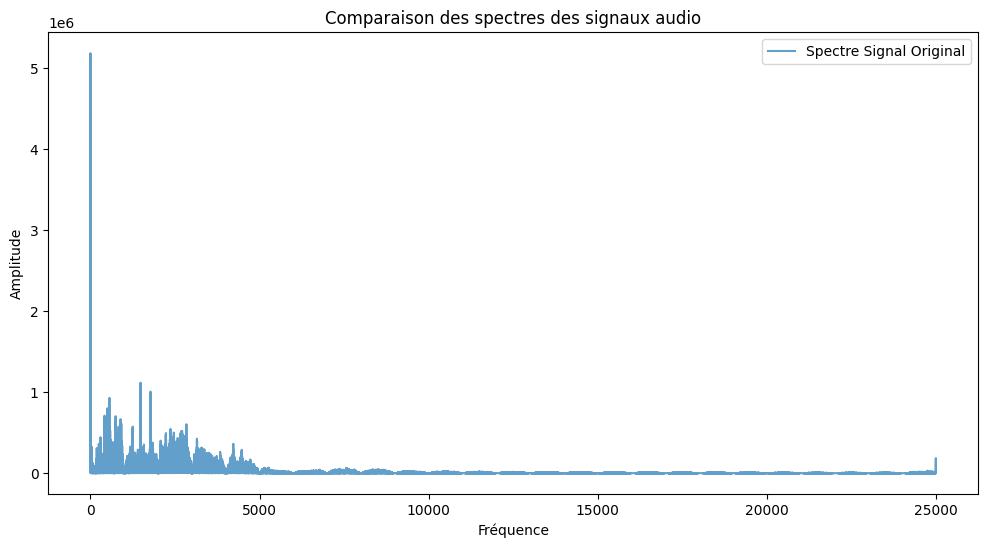

In [130]:
audio=filtered_audio.copy()

#Suppression de la composante DC
audio_amplified=audio-np.mean(audio[:250000])
#Fenetrage de Hamming
hamming_window = np.hamming(len(audio_amplified))
audio_amplified = audio_amplified*hamming_window
# Calcul de la FFT pour les deux signaux
fft_audio_original = np.abs(fft(audio_amplified))
xf_original = fftfreq(len(audio_amplified), 1/fs)


# Prendre la moitié positive des fréquences
indices_positifs = xf_original > 0
xf_original = xf_original[indices_positifs]
fft_audio_original = np.abs(fft_audio_original[indices_positifs])
# Affichage des spectres
print(fft_audio_original.shape, xf_original.shape, fft_audio_resampled.shape, xf_resampled.shape)

plt.figure(figsize=(12, 6))
plt.plot(xf_original,fft_audio_original, label='Spectre Signal Original', alpha=0.7)
plt.legend()
plt.title('Comparaison des spectres des signaux audio')
plt.xlabel('Fréquence')
plt.ylabel('Amplitude')
plt.show()

#Realisation d'un spectrogramme de mes données (james bond)


In [147]:
from scipy.signal import spectrogram


def generateSpectrogram(audio, fs=50000, window='hamming', nperseg=1024, noverlap=512, scaling='density'):
    
    # Calcul du spectrogramme
    frequencies, times, Sxx = spectrogram(audio, fs, window='hamming', nperseg=1024, noverlap=512, scaling='density')

    # Affichage du spectrogramme
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Intensité (dB)')
    plt.title('Spectrogramme du signal audio')
    plt.xlabel('Temps (s)')
    plt.ylabel('Fréquence (Hz)')
    plt.ylim(0, fs / 2)
    plt.show()

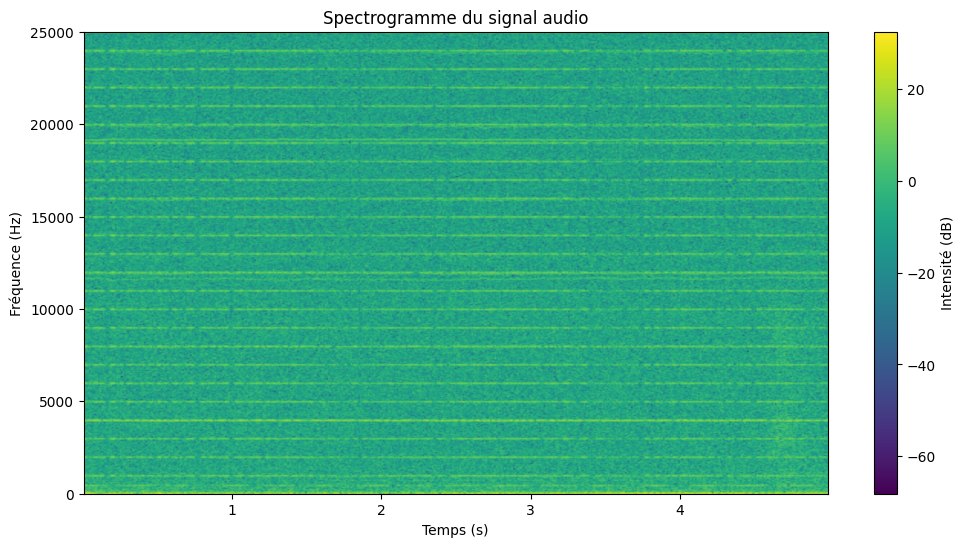

In [160]:
# Paramètres du signal
fs = 50000  # Fréquence d'échantillonnage (en Hz)
audio=soundValues.copy()
audio_amplified=np.int16(audio/np.max(np.abs(audio))*(2**15-1))
generateSpectrogram(audio_amplified[:250000], fs=fs)

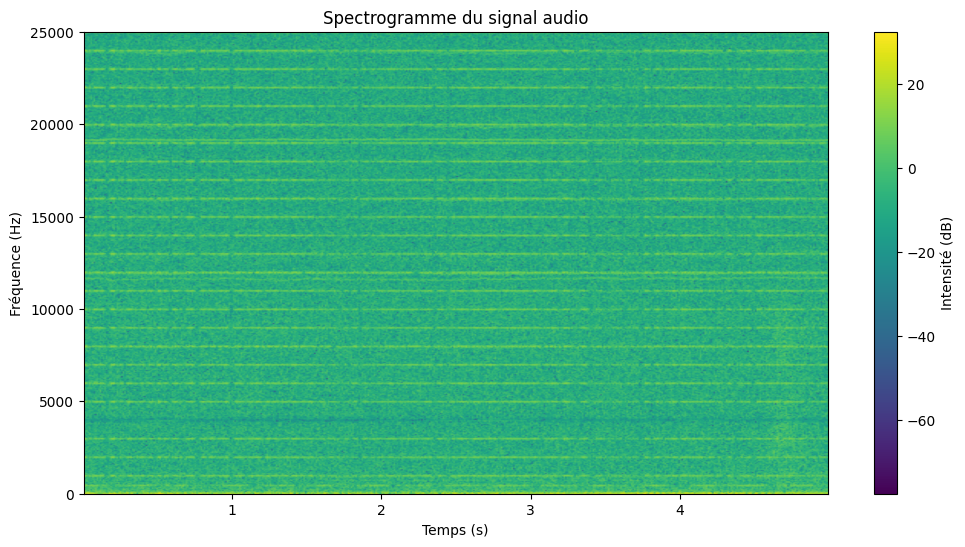

In [166]:
#Filter data at 4kHz (according to spectrogram)
f0 = 4000  # Fréquence à atténuer (Hz)
fs = 50000  # Fréquence d'échantillonnage (Hz)
Q = 30.0    # Facteur de qualité

filtered_audio=soundValues.copy()
filtered_audio=np.int16(filtered_audio/np.max(np.abs(filtered_audio))*(2**15-1))
# Conception du filtre notch

b, a =signal.iirnotch(f0, Q, fs)
filtered_audio=signal.filtfilt(b,a,filtered_audio)
generateSpectrogram(filtered_audio[:250000], fs=fs)

In [ ]:
audio_play(filtered_audio, sample_rate=fs)
audio_play(audio_amplified, sample_rate=fs)

In [ ]:
noise_reduction_audio